In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from analysis_funcs import *
from external_flux import *

In [3]:
import glob
import re

In [4]:
getobmt = lambda x: int(re.search("(?<=OBMT_START_)[0-9]+",x).group(0))

# In SM

In [8]:
# get all paths
allpaths = glob.glob("../output/SM/*/*/*/SM-SIF_OBMT_START_*.fits")
allpaths.sort(key = getobmt)

In [9]:
pathtimes_rev = np.array([getobmt(p) for p in allpaths])/(1e9*3600*6)

def psel_rev(start,stop):
    indices = np.where(np.logical_and(pathtimes_rev>=start, pathtimes_rev<=stop))[0]
    return [allpaths[ii] for ii in indices]


pathtimes_mjd = OBMT_apyTime(np.array([getobmt(p) for p in allpaths])).mjd

def psel_mjd(start,stop):
    indices = np.where(np.logical_and(pathtimes_mjd>=start, pathtimes_mjd<=stop))[0]
    return [allpaths[ii] for ii in indices]

In [10]:
len(allpaths)

1136

# Energy histograms

In [10]:
testE = fits_energies_edgeless(psel_mjd(57500,57550))

In [11]:
#testE2 = fits_energies_edgeless(psel_mjd(56715,56720))
testE2 = fits_energies_edgeless(psel_mjd(58006,58012))

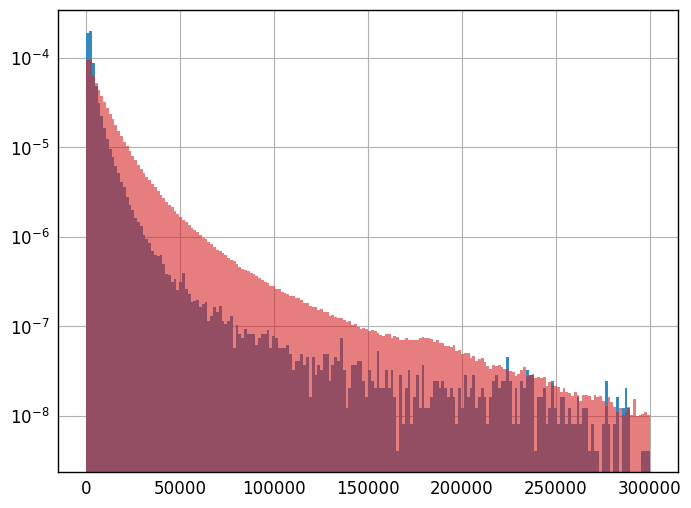

In [12]:
h1 = plt.hist(concatenate_energies(testE[1], range(len(testE[1]))), 200, range=(0,300000), normed=True, log=True)
h2 = plt.hist(concatenate_energies(testE2[1], range(len(testE2[1]))),200, range=(0,300000),normed=True, log=True,
                 color="tab:red", alpha=0.6)

Interesting very high energy behaviour, some sort of bump

Test: Instead of normalizing by the total number of particles, take the flux into account as well

In [34]:
# There is actually no need to go and calculate the geometry factors - we just need to normalize using the flux
# I.e.: The integral over the histogram (dE) has to be equal to the (mean, when using multiple obs) flux!

flux1 = fits_flux(psel_mjd(57500,57550))[2]
flux2 = fits_flux(psel_mjd(58006,58012))[2]

In [35]:
def energyHist_fluxnormed(obsEn, obsFluxes, bins=None, enrange=None):
    """
    Given a list of energy arrays and a list of the fluxes of the corresponding observations,
    make a normed energy histogram - each observation is normed by its geometry factor and then averaged over
    The output histogram is counts/cm^2/s/eV
    """
    nobs = len(obsFluxes)
    Eflat = concatenate_energies(obsEn, range(nobs))
    normflat = np.empty(len(Eflat))
    
    # determine the weights
    start = 0
    for ii in range(nobs):
        nParticles = len(obsEn[ii])
        normflat[start:start+nParticles] = obsFluxes[ii]/nParticles
        start += +nParticles
    
    normflat /= nobs
    # compute the weighted histogram
    histout = np.histogram(Eflat,bins=bins,range=enrange, weights=normflat)
    
    # divide by bin size
    step = histout[1][1] - histout[1][0]
    #step=1
    
    return histout[0]/step, histout[1]

In [36]:
nhist1 = energyHist_fluxnormed(testE[1],flux1,200,(0,300000))
nhist2 = energyHist_fluxnormed(testE2[1][100:200],flux2[100:200],200,(0,300000))

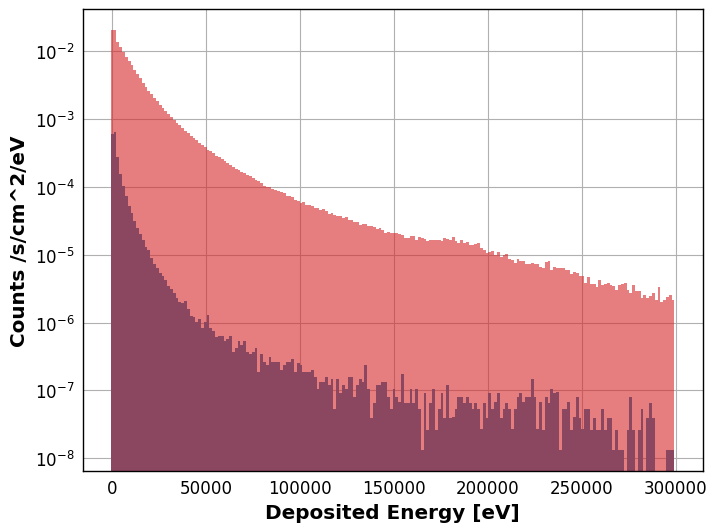

In [37]:
plt.bar(nhist1[1][:len(nhist1[0])], nhist1[0], nhist1[1][1]-nhist1[1][0], color="tab:blue")
plt.bar(nhist2[1][:len(nhist2[0])], nhist2[0], nhist2[1][1]-nhist2[1][0], color="tab:red",alpha=0.6)

plt.xlabel("Deposited Energy [eV]")
plt.ylabel("Counts /s/cm^2/eV")

plt.yscale('log')

# BAM

There are some strange fluxes around, for instance June 22 2016. Why?

In [35]:
out = fits_flux(glob.glob('../output/BAM/2016/08/22/*'))
#out = fits_flux(['../output/BAM/2015/10/29/BAM-OBS1_OBMT_START_63144863510957904.fits'])

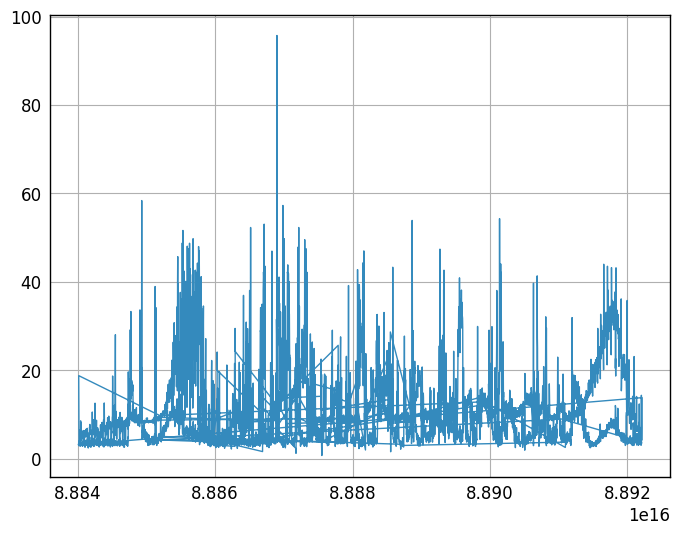

In [36]:
plt.plot(out[0],out[2])

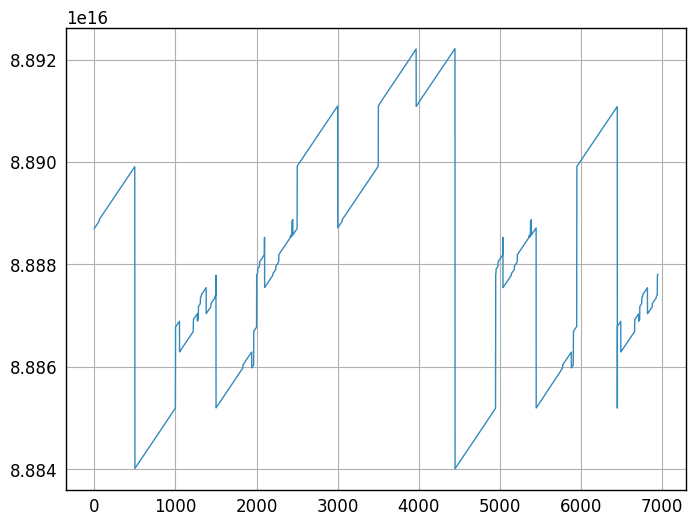

In [37]:
plt.plot(out[0])

-> As suspected, the times are totally messed up, messing up the reconstruction as well

In [38]:
EB1 = fits_energies_edgeless(glob.glob('../output/BAM/2016/08/22/*'))
EB2 = fits_energies_edgeless(glob.glob('../output/BAM/2016/08/20/*'))

In [39]:
fluxB1 = out[1]
fluxB2 = fits_flux(glob.glob('../output/BAM/2016/08/20/*'))[1]

<Container object of 100 artists>

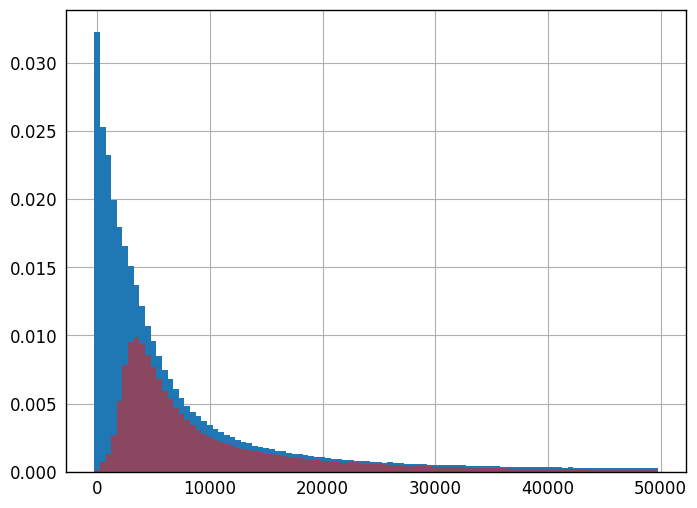

In [44]:
nhistB1 = energyHist_fluxnormed(EB1[1],fluxB1,100,(0,50000))
nhistB2 = energyHist_fluxnormed(EB2[1],fluxB2,100,(0,50000))
plt.bar(nhistB1[1][:len(nhistB1[0])], nhistB1[0], nhistB1[1][1]-nhistB1[1][0], color="tab:blue")
plt.bar(nhistB2[1][:len(nhistB2[0])], nhistB2[0], nhistB2[1][1]-nhistB2[1][0], color="tab:red",alpha=0.6)

-> Almost all the excess is low energy stuff, so light.

# BAM-OBS vs BAM-SIF

In [72]:
EB = fits_energies_edgeless(sorted(glob.glob('../output/BAM/2016/08/20/BAM-OBS2*'))[0])[1]
EBS = fits_energies_edgeless(sorted(glob.glob('../output/BAM-SIF/2016/*/*/*')),fov=2)[1]

In [73]:
fluxB = fits_flux(sorted(glob.glob('../output/BAM/2016/08/20/BAM-OBS2*'))[0])[2]
fluxBS = fits_flux(sorted(glob.glob('../output/BAM-SIF/2016/*/*/*')),fov=2)[2]

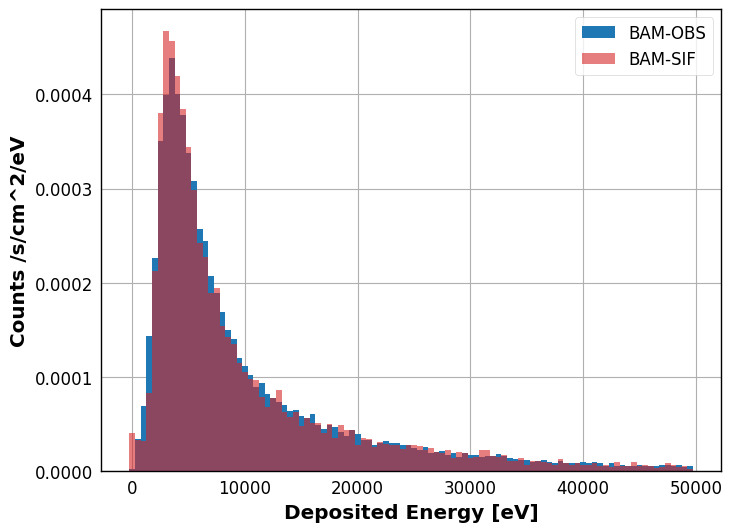

In [74]:
nhistB = energyHist_fluxnormed(EB,fluxB,100,(0,50000))
nhistBS = energyHist_fluxnormed(EBS,fluxBS,100,(0,50000))
plt.bar(nhistB[1][:len(nhistB[0])], nhistB[0], nhistB[1][1]-nhistB[1][0], color="tab:blue", label='BAM-OBS')
plt.bar(nhistBS[1][:len(nhistBS[0])], nhistBS[0], nhistBS[1][1]-nhistBS[1][0], color="tab:red",alpha=0.6,label='BAM-SIF')
plt.legend(loc='best')

plt.xlabel("Deposited Energy [eV]")
plt.ylabel("Counts /s/cm^2/eV")

-> Not much of a difference, although some more in FOV 2. This may be due to the stronger pattern, or poisson noise since we sample a smaller area in FOV 2.

# BAM-OBS: Flare vs quiet

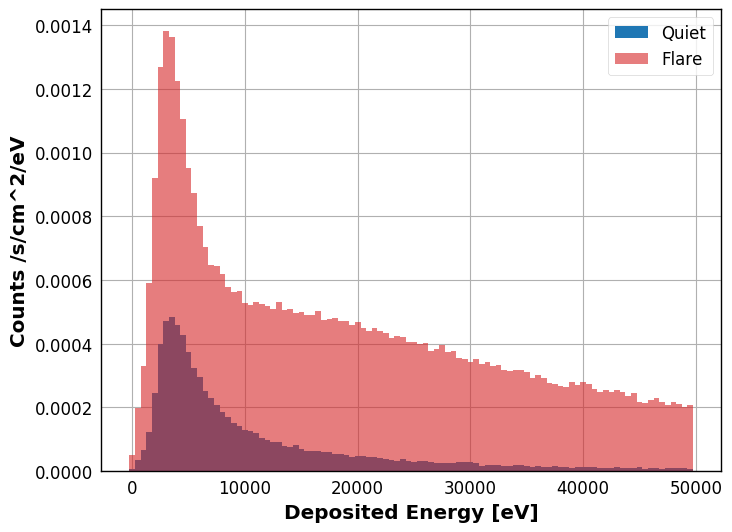

In [89]:
EB1 = fits_energies_edgeless(sorted(glob.glob('../output/BAM/2017/09/14/BAM-OBS1*'))[-1])[1]
#EB2 = fits_energies_edgeless(sorted(glob.glob('../output/BAM/2017/09/10/BAM-OBS1*'))[6])[1][:200] # specifically the onset of the flare
EB2 = fits_energies_edgeless(sorted(glob.glob('../output/BAM/2017/09/12/BAM-OBS1*'))[0])[1] # the tail

fluxB1 = fits_flux(sorted(glob.glob('../output/BAM/2017/09/14/BAM-OBS1*'))[-1])[2]
#fluxB2 = fits_flux(sorted(glob.glob('../output/BAM/2017/09/10/BAM-OBS1*'))[6])[2][:200]
fluxB2 = fits_flux(sorted(glob.glob('../output/BAM/2017/09/12/BAM-OBS1*'))[0])[2] # the tail


nhistB1 = energyHist_fluxnormed(EB1,fluxB1,100,(0,50000))
nhistB2 = energyHist_fluxnormed(EB2,fluxB2,100,(0,50000))


plt.bar(nhistB1[1][:len(nhistB1[0])], nhistB1[0], nhistB1[1][1]-nhistB1[1][0], 
        color="tab:blue", label='Quiet',log=False)
plt.bar(nhistB2[1][:len(nhistB2[0])], nhistB2[0], nhistB2[1][1]-nhistB2[1][0], 
        color="tab:red",alpha=0.6,label='Flare',log=False)
plt.legend(loc='best')

plt.xlabel("Deposited Energy [eV]")
plt.ylabel("Counts /s/cm^2/eV")

Almost looks like a second population of particles during the flare.

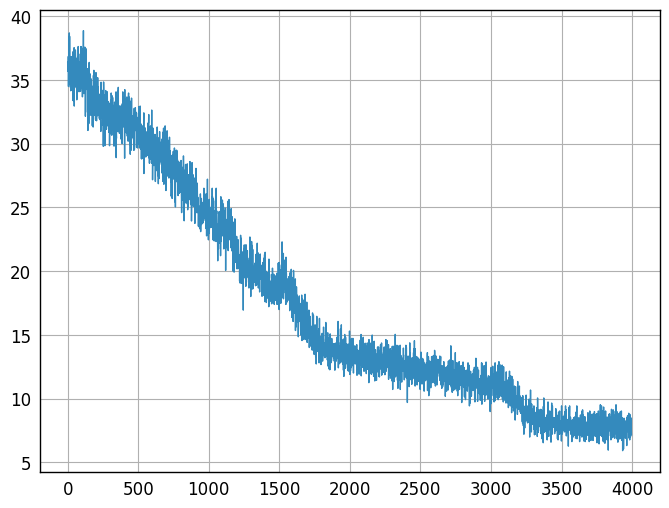

In [86]:
plt.plot(fits_flux(sorted(glob.glob('../output/BAM/2017/09/12/BAM-OBS2*')))[2])